<a href="https://colab.research.google.com/github/ouyhlan/nlp-beginner-practice/blob/main/Task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('drive/MyDrive/Colab/Task2')

## 1.数据处理

### 1.1 数据统计

In [ ]:
import numpy as np
import pandas as pd

# (156060, 4) PhraseId SentenceId Phrase Sentiment
datas = pd.read_csv('dataset/train.tsv', sep='\t')

# (156060, 2) Phrase Sentiment
datas = datas[["Phrase", "Sentiment"]]

datas

,Phrase,Sentiment
0,A series of escapades demonstrating the adage ...,1
1,A series of escapades demonstrating the adage ...,2
2,A series,2
3,A,2
4,series,2
...,...,...
156055,Hearst 's,2
156056,forced avuncular chortles,1
156057,avuncular chortles,3
156058,avuncular,2


### 1.2 划分数据集

In [ ]:
# 随机划分 训练集:验证集:测试集 = 6:2:2 
seed = 18340133
index_arr = np.arange(datas.shape[0])

np.random.seed(seed)
np.random.shuffle(index_arr)  # 打乱序号

train_begin, train_end = 0, int(len(datas) * 0.6)
val_begin, val_end = train_end, int(len(datas) * 0.8)
test_begin = val_end

# 保存划分结果
datas.iloc[index_arr[:train_end], :].to_csv('dataset/train.csv', index=False)
datas.iloc[index_arr[val_begin:val_end], :].to_csv('dataset/val.csv', index=False)
datas.iloc[index_arr[test_begin:], :].to_csv('dataset/test.csv', index=False)

### 1.3 统计句子长度分布
统计训练集句子长度分布，用于后续决定padding的长度

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
53


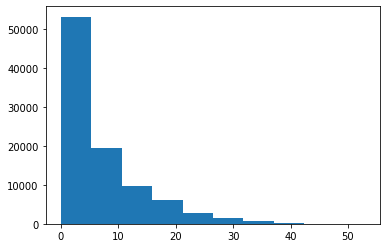

In [ ]:
import nltk
import matplotlib.pyplot as plt
nltk.download('punkt')

# 统计句子长度分布
train_datas = pd.read_csv('dataset/train.csv')
len_arr = [len(nltk.word_tokenize(x)) for x in train_datas['Phrase']]
plt.hist(len_arr)
print(max(len_arr))

数据集里的句子长度以5以内为主。但考虑到还有较长的句子，这里padding最后的长度设为60。

### 1.4 建立词表
预训练词向量采用的是glove

In [ ]:
import pandas as pd
import numpy as np
import nltk

nltk.download("punkt")

# 建立词表
class VocabProcessor():
    def run(self, train_path="dataset/train.csv", glove_path="../glove/glove.6B.300d.txt"):
        glove = self.processGlove(glove_path)
        vocab = self.buildVocab(train_path, glove)
        return vocab    

    # 读取GloVe文件
    def processGlove(self, glove_path):
        word2idx = {}
        vectors = []
        with open(glove_path) as fp:
            lines = fp.readlines()
            
            for i, line in enumerate(lines):
                line = line.strip('\n').split()
                word2idx[line[0]] = i 
                vectors.append(np.array(list(map(float, line[1:])), dtype=np.float32))
            fp.close()
        
        return {"word2idx":word2idx, "glove_vectors":vectors}

    # 利用训练集建立词表
    def buildVocab(self, train_path, glove):
        vocab = ['<pad>', '<unk>']
        word2idx = {'<pad>':0, '<unk>':1}
        
        lines = pd.read_csv(train_path)["Phrase"]

        curr_idx = 2
        for line in lines:
            # 首先进行分词
            line = nltk.word_tokenize(line)

            # 逐个词进行判断
            for word in line:
                # 如果词不在glove的词表里或词已经在词表里，则跳过
                if not (word in glove["word2idx"]) or word in word2idx:
                    continue
                else:
                    vocab.append(word)
                    word2idx[word] = curr_idx
                    curr_idx = curr_idx + 1

        
        # 建立词向量大矩阵
        glove_vectors = np.zeros((len(vocab), 300), dtype=np.float32)

        # 随机初始化<unk>
        glove_vectors[1] = np.random.randn((300))

        for i in range(2, len(vocab)):
            word = vocab[i]
            glove_idx = glove["word2idx"][word]
            glove_vectors[i] = glove["glove_vectors"][glove_idx]

        return {"word2idx":word2idx, "glove_vectors":glove_vectors}

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
vocab_processor = VocabProcessor()
glove_vocab = vocab_processor.run()

以glove给出的词表和训练集上出现过的词语综合为最后使用的词表，遇到不在此表里的词以`<unk>`表示

### 1.5 向量化数据集

In [ ]:
import torch.utils.data

class TextDataset(torch.utils.data.Dataset):
    def __init__(self, path, vocab, padding_length):
        super(TextDataset).__init__()
        self.datas = []
        datas = pd.read_csv(path)

        unk_idx = vocab['word2idx']['<unk>']
        for index, line in datas.iterrows():
            cur_line = np.zeros((padding_length), dtype=np.long)   # <pad> : 0

            # 分词
            text = nltk.word_tokenize(line["Phrase"])
            length = min(len(text), padding_length)

            # 序列化
            for i, word in enumerate(text):
                if i >= padding_length:
                    break

                if not (word in vocab["word2idx"]): # 不在词表的词
                    cur_line[i] = unk_idx
                else:
                    word_idx = vocab['word2idx'][word]
                    cur_line[i] = word_idx
            
            self.datas.append({"text":cur_line, "length":length, "label":line["Sentiment"]})
    
    def __getitem__(self, index):
        data = self.datas[index]
        text = torch.Tensor(data["text"]).long()
        length = data["length"]
        label = data["label"]
        return (text, length, label)
    
    def __len__(self):
        return len(self.datas)

In [ ]:
train_path = "dataset/train.csv"
val_path = "dataset/val.csv"
test_path = "dataset/test.csv"

train_dataset = TextDataset(train_path, glove_vocab, 60)
val_dataset = TextDataset(val_path, glove_vocab, 60)
test_dataset = TextDataset(test_path, glove_vocab, 60)

In [ ]:
val_dataset[0]

(tensor([  35,  546,   39,   97,  469,   14, 3061,   50,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]),
 8,
 2)

## 2. TextCNN模型
根据Convolutional Neural Networks for Sentence Classification https://arxiv.org/abs/1408.5882 采用三种卷积核，大小分别为3，4，5。
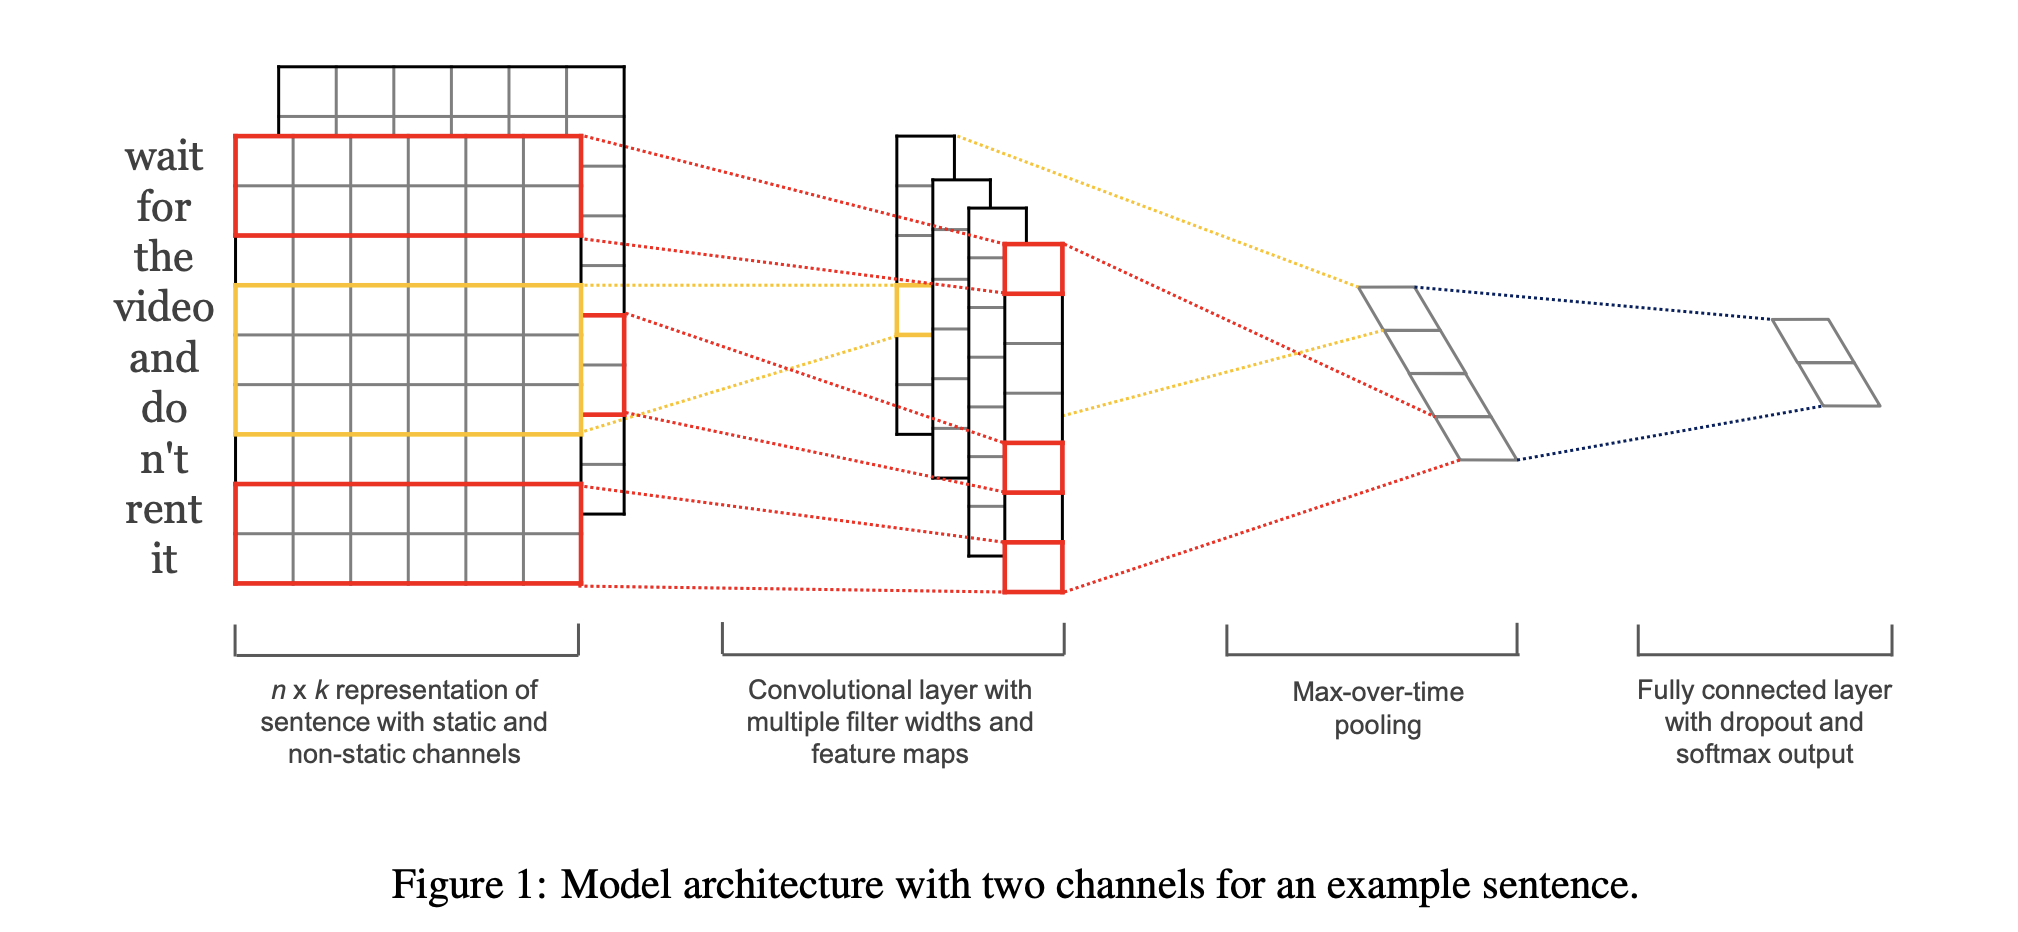

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class TextCNN(nn.Module):
    def __init__(self, args, vocab):
        super(TextCNN, self).__init__()
        self.args = args

        # Embedding Layer
        self.embedding = nn.Embedding.from_pretrained(vocab, freeze=True)

        # Covolutional Layer
        self.conv1 = nn.Conv1d(in_channels=args.embed_size,
                               out_channels=args.filter_size,
                               kernel_size=3,
                               padding=2)
        
        self.conv2 = nn.Conv1d(in_channels=args.embed_size,
                               out_channels=args.filter_size,
                               kernel_size=4,
                               padding=3)
        
        self.conv3 = nn.Conv1d(in_channels=args.embed_size,
                               out_channels=args.filter_size,
                               kernel_size=5,
                               padding=4)

        # Pooling Layer
        # 1-max pooling
        self.maxpool = nn.MaxPool1d(kernel_size=args.padded_length)

        # Dropout Layer
        self.dropout = nn.Dropout(args.dropout_rate)

        # Full-connected Layer
        self.fc = nn.Linear(args.filter_size * 3, args.label_num)

    def forward(self, x):
        # Embedding Layer
        # (batch_size, length) -> (batch_size, length, embed_dim)
        embed = self.embedding(x)

        # Convolutional Layer
        # (batch_size, length, embed_dim) -> (batch_size, embed_dim, length)
        conv_input = embed.permute(0, 2, 1)
        
        # (batch_size, embed_dim, length) -> (batch_size, filter_size, length)
        conv1_output = self.conv1(conv_input)
        conv2_output = self.conv2(conv_input)
        conv3_output = self.conv2(conv_input)
        
        # Pooling Layer
        # (batch_size, filter_size, length) -> (batch_size, filter_size)
        out1 = self.maxpool(conv1_output).view(-1, self.args.filter_size)
        out2 = self.maxpool(conv2_output).view(-1, self.args.filter_size)
        out3 = self.maxpool(conv3_output).view(-1, self.args.filter_size)

        # (batch_size, filter_size * 3)
        out = torch.cat((out1, out2, out3), dim=1)

        # Dropout Layer
        out = self.dropout(out)

        # Full-connected Layer
        out = self.fc(out)
        
        return out

## 3. 训练函数

In [ ]:
def train_progress(args, model, optimizer, criterion, train_dataloader, val_dataloader, test_dataloader, device):
    train_acc_arr = []
    train_loss_arr = []
    val_acc_arr = []
    val_loss_arr = []
    best_val_acc = 0.
    best_val_epoch = -1
    
    for epoch in range(args.epochs):
        print(f"Epoch {epoch}:")

        # Training
        train_len = 0
        train_loss = 0.
        train_acc = 0.

        model.train()
        for step, datas in enumerate(train_dataloader):
            optimizer.zero_grad()
            text, length, labels = [data.to(device) for data in datas]
            
            labels = labels.cpu()
            output = model(text).cpu()
            loss = criterion(output, labels)
            pred = torch.argmax(output.view(-1, args.label_num), dim=-1)
            acc = (pred == labels).float().sum()
            
            # 训练
            loss.backward()
            optimizer.step()

            # 统计结果
            size = labels.numel()
            train_len += size
            train_loss += loss.item()
            train_acc += acc
        
        train_loss = train_loss / train_len
        train_acc = train_acc / train_len
        train_loss_arr.append(train_loss)
        train_acc_arr.append(train_acc)
        print(f"Train: | loss: {train_loss} | acc: {train_acc}")

        # Validation
        val_len = 0
        val_loss = 0.
        val_acc = 0.

        model.eval()
        with torch.no_grad():
            for step, datas in enumerate(val_dataloader):
                text, length, labels = [data.to(device) for data in datas]
            
                labels = labels.cpu()
                output = model(text).cpu()
                loss = criterion(output, labels)
                pred = torch.argmax(output.view(-1, args.label_num), dim=-1)
                acc = (pred == labels).float().sum()

                # 统计结果
                size = labels.numel()
                val_len += size
                val_loss += loss.item()
                val_acc += acc
            
        val_loss = val_loss / val_len
        val_acc = val_acc / val_len
        val_loss_arr.append(val_loss)
        val_acc_arr.append(val_acc)
        print(f"Validation: | loss: {val_loss} | acc: {val_acc}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_epoch = epoch
            torch.save(model.state_dict(), "models/best_model.pth")
        
        # Early stop
        if epoch - best_val_epoch >= 5:
            print("Early Stop!")
            break

    # Test
    best_checkpoint = torch.load("models/best_model.pth")
    model.load_state_dict(best_checkpoint)
    test_len = 0
    test_loss = 0.
    test_acc = 0.

    model.eval()
    with torch.no_grad():
        for step, datas in enumerate(test_dataloader):
            text, length, labels = [data.to(device) for data in datas]
        
            labels = labels.cpu()
            output = model(text).cpu()
            loss = criterion(output, labels)
            pred = torch.argmax(output.view(-1, args.label_num), dim=-1)
            acc = (pred == labels).float().sum()

            # 统计结果
            size = labels.numel()
            test_len += size
            test_loss += loss.item()
            test_acc += acc
        
    test_loss = test_loss / test_len
    test_acc = test_acc / test_len
    print(f"\n\nFinal test: | loss: {test_loss} | acc: {test_acc}")
    return (train_loss_arr, train_acc_arr), (val_loss_arr, val_acc_arr)

## 4. 训练和分析

### 4.1 超参数

In [ ]:
class Arguments():
    epochs = 50
    batch_size = 50
    lr = 5e-4
    embed_size = 300
    filter_size = 100
    padded_length = 60
    dropout_rate = 0.5
    label_num = 5

模型超参数参照论文

### 4.2 训练过程

In [ ]:
import torch.optim

args = Arguments()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vocab =  torch.Tensor(glove_vocab["glove_vectors"])
model = TextCNN(args, vocab)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
criterion = nn.CrossEntropyLoss()

if torch.cuda.is_available():
    model.cuda()

In [ ]:
import torch.utils.data

train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=args.batch_size,
                                           shuffle=True)
val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=args.batch_size,
                                           shuffle=False)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=args.batch_size,
                                           shuffle=False)

train_record, val_record = train_progress(args=args, 
                                          model=model,
                                          optimizer=optimizer,
                                          criterion=criterion,
                                          train_dataloader=train_dataloader, 
                                          val_dataloader=val_dataloader, 
                                          test_dataloader=test_dataloader, 
                                          device=device)

Epoch 0:
Train: | loss: 0.020450311351873533 | acc: 0.5934789776802063
Validation: | loss: 0.018510442644865652 | acc: 0.6165577173233032
Epoch 1:
Train: | loss: 0.018211830722954157 | acc: 0.6291170120239258
Validation: | loss: 0.01764788099447764 | acc: 0.6406510472297668
Epoch 2:
Train: | loss: 0.017305020136465312 | acc: 0.6498782634735107
Validation: | loss: 0.017257340728862307 | acc: 0.6494296789169312
Epoch 3:
Train: | loss: 0.016549737155730285 | acc: 0.6645841598510742
Validation: | loss: 0.017240151499427772 | acc: 0.6494617462158203
Epoch 4:
Train: | loss: 0.015964189388920646 | acc: 0.6774637699127197
Validation: | loss: 0.017017680691875252 | acc: 0.6584005951881409
Epoch 5:
Train: | loss: 0.015542829964876307 | acc: 0.6852492690086365
Validation: | loss: 0.016904959144094855 | acc: 0.6595219969749451
Epoch 6:
Train: | loss: 0.015179098926822279 | acc: 0.6942201852798462
Validation: | loss: 0.016972802432358273 | acc: 0.6574714779853821
Epoch 7:
Train: | loss: 0.014818118

### 4.3 结果分析

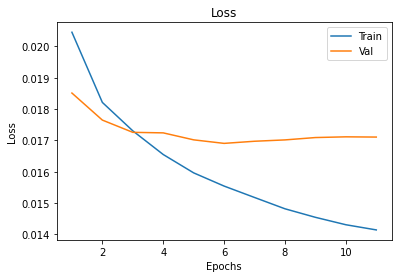

In [ ]:
import matplotlib.pyplot as plt

experiment_epoch = range(1, len(train_record[0]) + 1)
plt.plot(experiment_epoch, train_record[0], label='Train')
plt.plot(experiment_epoch, val_record[0], label='Val')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

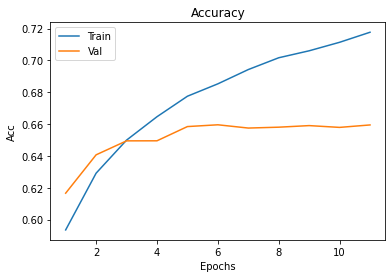

In [ ]:
experiment_epoch = range(1, len(train_record[1]) + 1)
plt.plot(experiment_epoch, train_record[1], label='Train')
plt.plot(experiment_epoch, val_record[1], label='Val')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

从上面两张图可以看出，训练集的损失值和正确率都还在变好，但是验证集已经趋向于收敛，模型训练基本完成。测试集上的结果是使用验证集上准确率最高对应的模型参数测出来的，准确率为65.32%